In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import random

con = sqlite3.connect("Northwind.db",isolation_level=None)
cur = con.cursor()

The Northwind database contains purchases of some products considering the details of costumers, shippers, type of product, etc.

The origin information of the costumers is available in the database, so we can ask ourselves the question: Is there a strong relationship between the goods purchased and the country?

Lets group the products by country 

In [2]:
query = """
            SELECT Customers.Country,Customers.CustomerID, group_concat(Orders.OrderID) as Orders_by_customer
            FROM Customers
            INNER JOIN Orders ON Orders.CustomerID=Customers.CustomerID
            GROUP BY Customers.CustomerID
            ORDER BY Customers.CustomerID;
        """
cur.execute(query)
X = cur.fetchall()
columns = [cur.description[0][0], cur.description[1][0], cur.description[2][0]]

ordersByCostumer = pd.DataFrame(X,columns=columns)
print(ordersByCostumer)

    Country  CustomerID                         Orders_by_customer
0    Mexico           2                                      10308
1    Mexico           3                                      10365
2        UK           4                                10355,10383
3    Sweden           5                          10278,10280,10384
4    France           7                    10265,10297,10360,10436
..      ...         ...                                        ...
69  Finland          87  10266,10270,10320,10333,10412,10416,10437
70   Brazil          88                                10256,10420
71      USA          89                                10269,10344
72  Finland          90                                      10248
73   Poland          91                                      10374

[74 rows x 3 columns]


Now that we have this table, we are interested in a table that has each country and the ProductID as columns. We want to group the total quantity purchased of each product in each country, regardless of which costumer bought how many of that product.

In [ ]:
# We make this query to know the number of products in the database
query = """
            SELECT MAX(ProductID) FROM Products;
        """
cur.execute(query)
X = cur.fetchall()
maxProduct = X[0][0]

rows = len(ordersByCostumer)

# This is the dataframe in which we'll have the products purchased
# in each country
ordersByCountry = pd.DataFrame(index = range(1,maxProduct+1))

# Now we want the list of different countries
countries = []

for i in range(rows):
    ordersByCountry[ordersByCostumer.iloc[i,0]] = 0
    if ordersByCostumer.iloc[i,0] not in countries:
        countries.append(ordersByCostumer.iloc[i,0])
    
# print(countries)


for i in range(rows):

    orders = ordersByCostumer.iloc[i,2].split(',')
    print(orders)
    for order in orders:
        query = f"""
            SELECT OrderID, ProductID, Quantity
            FROM OrderDetails
            WHERE OrderID = {order};
        """
        print(query)
        cur.execute(query)
        X = cur.fetchall()

        for row in X:
            ordersByCountry.loc[row[1],str(ordersByCostumer.iloc[i,0])] += row[2]

        print(X)

ordersByCountry.reset_index(inplace=True)
ordersByCountry.rename(columns={'index': 'ProductID'}, inplace=True)

# We will add this new table to the existing database, first 
# we create the table
queryFragment = ""

for country in countries:
    queryFragment += country + " INTEGER,"

queryFragment = queryFragment[:-1]

query = """
            CREATE TABLE OrdersByCountry (
	        ProductID INTEGER,
        """ + queryFragment + ");"

print(query)
cur.execute(query)

# We can see the full table with this print
# print(ordersByCountry.to_string())


Now that we created this new table in the database, we insert the records.

In [ ]:
for i in range(len(ordersByCountry)):
    queryFragment1 = ""
    queryFragment2 = ""

    for country in countries:
        queryFragment1 += country + ", "
        queryFragment2 += str(ordersByCountry.loc[i,country]) + ", "

    queryFragment1 = queryFragment1[:-2]
    queryFragment2 = queryFragment2[:-2]

    query = "INSERT INTO OrdersByCountry (ProductID, " + queryFragment1 + """)
        """+"VALUES ("+str(ordersByCountry.loc[i,'ProductID'])+", " + queryFragment2+ ");"

    print(query)
    cur.execute(query)

We normalize the values by country. This is, we register the proportion of each product quantity of the total purchased quantity of the country. 

In [7]:
# We get the total amount of products bought in each country
productsByCountry = ordersByCountry.sum(axis = 0)

# This is the new dataframe
normalizedOrders = pd.DataFrame()

for country in countries:
    normalizedOrders[country] = ordersByCountry[country] / productsByCountry[country]

print(normalizedOrders)

      Mexico        UK    Sweden    France     Spain    Canada  Switzerland  \
0   0.052402  0.000000  0.000000  0.026997  0.000000  0.000000     0.048077   
1   0.000000  0.014327  0.150376  0.000000  0.000000  0.000000     0.064103   
2   0.000000  0.042980  0.000000  0.000000  0.000000  0.000000     0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.099585  0.012953     0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000     0.000000   
..       ...       ...       ...       ...       ...       ...          ...   
72  0.000000  0.000000  0.062657  0.000000  0.000000  0.000000     0.000000   
73  0.000000  0.000000  0.000000  0.000000  0.000000  0.038860     0.131410   
74  0.026201  0.000000  0.075188  0.026997  0.207469  0.000000     0.000000   
75  0.131004  0.008596  0.045113  0.038245  0.000000  0.000000     0.000000   
76  0.000000  0.000000  0.000000  0.000000  0.020747  0.000000     0.000000   

      Brazil   Germany   Austria  ...  Portugal  Ve

Now, we can take samples of 9 products and plot the quantities bought of these products by each country. By doing this we have a random sample describing the situation but also not too much information at the same time. We can do the random sampling many times.

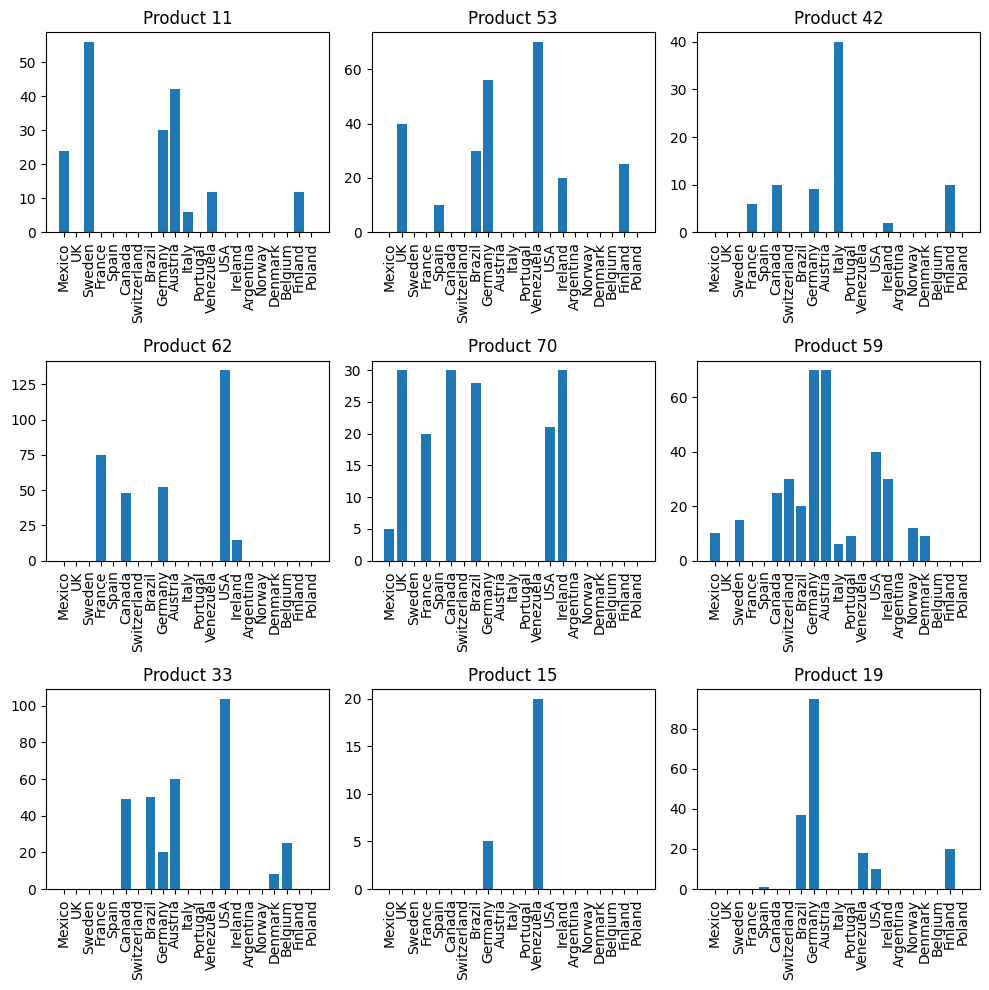

In [5]:
def plotProduct(prod,axs):
    axs.bar(countries,ordersByCountry.iloc[prod-1,:][1:])
    axs.set_title(f'Product {prod}')
    

random_subset = random.sample(range(1,maxProduct + 1), 9)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))


for i in range(9):
    plt.xticks(rotation=90)
    plotProduct(random_subset[i],axs[int(i/3),i%3])

for ax in axs.flat:
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()

plt.savefig('products.png')
plt.show()


With the purpose of having a general view of all this information, we plot the total amounts of products acquired by each country divided by colors into the quantities of each product. We also plot the same information but considering the normalized table. In this way, we can compare countries based on the acquisition proportions for each one.

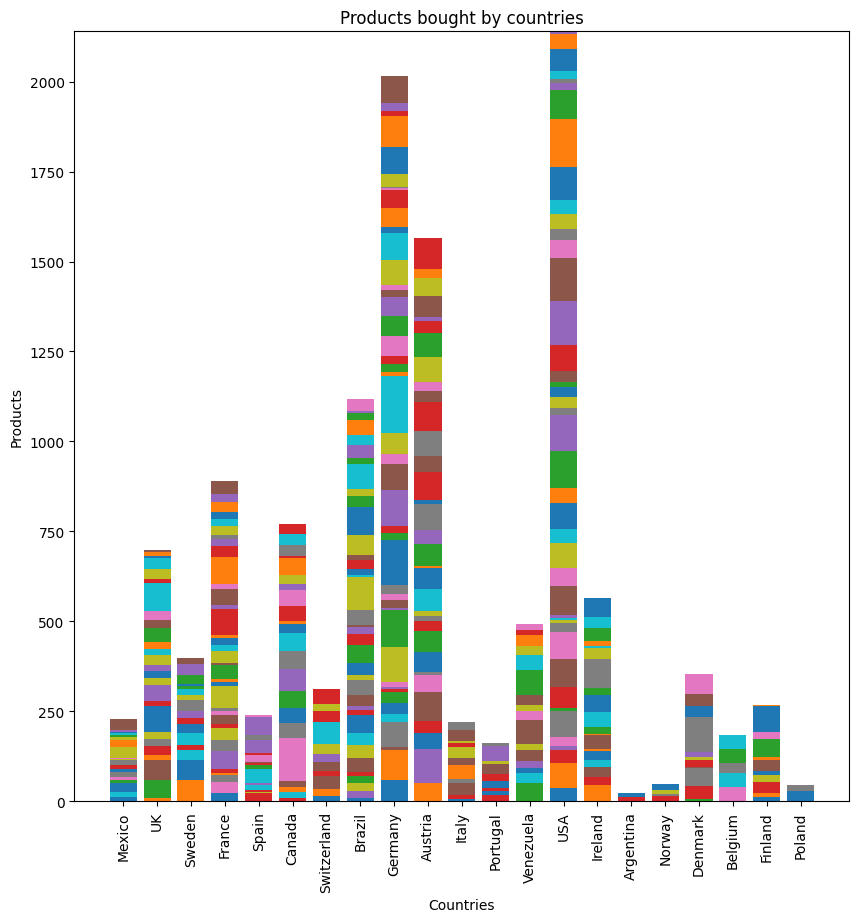

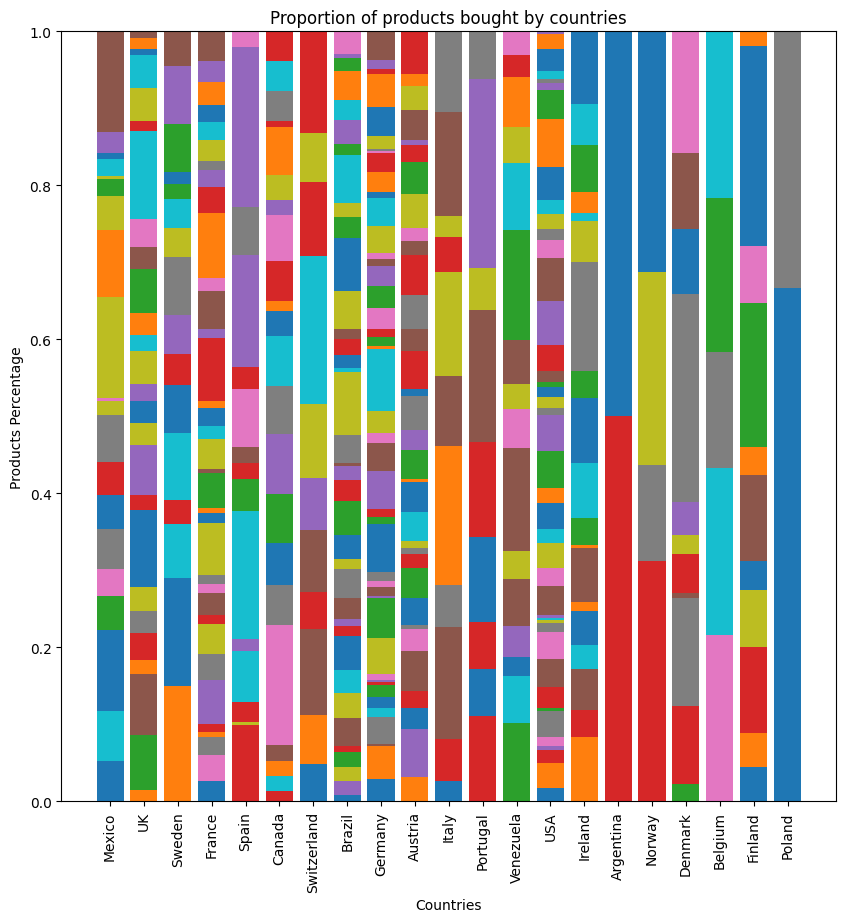

In [9]:
# This function plots a stacked bars plot
def plotBars(dataPlotted,xLabel,yLabel,title):

    fig, axs = plt.subplots(1, 1, figsize=(10, 10))

    for i in range(maxProduct):

        if i == 0:
            axs.bar(categories, dataPlotted.iloc[i,:],label='1')
        else:
            topOfBars = [sum(L) for L in zip(*dataPlotted.iloc[:i,:].values.tolist())]
            axs.bar(categories, dataPlotted.iloc[i,:], bottom=topOfBars[:], label=f'{i+1}')

    # Add labels and legend
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.xticks(rotation=90)
    plt.title(title)
    #plt.legend()

    plt.savefig(f'{title}.png')
    # Show plot
    plt.show()


# Countries for the bars
categories = countries
# Product ID's
subcategories = range(1,maxProduct + 1)

values = range(maxProduct + 1)

# Total products purchased
data = ordersByCountry.iloc[:,1:]

plotBars(data,"Countries", "Products", 'Products bought by countries')

# Normalized products purchased
data = normalizedOrders

plotBars(data,"Countries", "Products Percentage", 'Proportion of products bought by countries')


We see 3 country outliers by the total quantity purchased (USA, Germany and Austria). On the other hand, we see a relative homogeneity in the purchased quantities of each product. This is, we don't see a product that has a notorious share in a bar. We see in the second plot some products that have a huge share in the country's quantity, but this happens when the country didn't purchase a lot of total product.

Based on this analysis, we can take the 3 top outliers and derive an analysis now focusing in the products category. We can see how the products categories distribute in this top 3 outliers and compare this distributions. There are 8 product
categories as we can see from the Categories table:

In [12]:
query = """
            SELECT * FROM Categories;
        """
cur.execute(query)
X = cur.fetchall()

columns = [cur.description[0][0], cur.description[1][0], cur.description[2][0]]

Categories = pd.DataFrame(X,columns=columns)
print(Categories)

   CategoryID    CategoryName  \
0           1       Beverages   
1           2      Condiments   
2           3     Confections   
3           4  Dairy Products   
4           5  Grains/Cereals   
5           6    Meat/Poultry   
6           7         Produce   
7           8         Seafood   

                                         Description  
0        Soft drinks, coffees, teas, beers, and ales  
1  Sweet and savory sauces, relishes, spreads, an...  
2                Desserts, candies, and sweet breads  
3                                            Cheeses  
4                Breads, crackers, pasta, and cereal  
5                                     Prepared meats  
6                          Dried fruit and bean curd  
7                                   Seaweed and fish  


Now we can join this table with the OrdersByCountry table and take the countries that we want.

In [15]:
query = """
            SELECT Products.ProductID, OrdersByCountry.Germany, 
                    OrdersByCountry.Austria, OrdersByCountry.USA, Products.CategoryID FROM Products
            INNER JOIN OrdersByCountry ON Products.ProductID = OrdersByCountry.ProductID;
        """
cur.execute(query)
X = cur.fetchall()

columns = [cur.description[0][0], cur.description[1][0], cur.description[2][0], cur.description[3][0], cur.description[4][0]]

Categories = pd.DataFrame(X,columns=columns)
print(Categories)

    ProductID  Germany  Austria  USA  CategoryID
0           1       60        0   38           1
1           2       84       50   70           1
2           3        0        0    0           2
3           4        0        0   35           2
4           5        0       97   12           2
..        ...      ...      ...  ...         ...
72         73        0        0    0           8
73         74       15       86    0           7
74         75       22        0    6           1
75         76       75        0    0           1
76         77        0        0    0           2

[77 rows x 5 columns]


Now we group by categories and sum the quantities in each category.

In [19]:
CategoriesGermany = Categories.groupby('CategoryID').Germany.sum()
print("Germany")
print(CategoriesGermany)

CategoriesAustria = Categories.groupby('CategoryID').Austria.sum()
print("Austria")
print(CategoriesAustria)

CategoriesUSA = Categories.groupby('CategoryID').USA.sum()
print("USA")
print(CategoriesUSA)

Germany
CategoryID
1    448
2    118
3    249
4    516
5    199
6    123
7     48
8    314
Name: Germany, dtype: int64
Austria
CategoryID
1    188
2    309
3    206
4    312
5    150
6    139
7    134
8    127
Name: Austria, dtype: int64
USA
CategoryID
1    300
2    307
3    379
4    401
5    172
6    336
7     82
8    162
Name: USA, dtype: int64


Now we print the normalized quantities.

In [31]:
normalizedCategoriesGermany = CategoriesGermany / sum(CategoriesGermany)
normalizedCategoriesAustria = CategoriesAustria / sum(CategoriesAustria)
normalizedCategoriesUSA = CategoriesUSA / sum(CategoriesUSA)

print("Germany")
print(normalizedCategoriesGermany)

print("Austria")
print(normalizedCategoriesAustria)

print("USA")
print(normalizedCategoriesUSA)

Germany
CategoryID
1    0.222333
2    0.058561
3    0.123573
4    0.256079
5    0.098759
6    0.061042
7    0.023821
8    0.155831
Name: Germany, dtype: float64
Austria
CategoryID
1    0.120128
2    0.197444
3    0.131629
4    0.199361
5    0.095847
6    0.088818
7    0.085623
8    0.081150
Name: Austria, dtype: float64
USA
CategoryID
1    0.140252
2    0.143525
3    0.177186
4    0.187471
5    0.080411
6    0.157083
7    0.038336
8    0.075736
Name: USA, dtype: float64


Now we sort the categories in each country. 

In [23]:
print("Germany")
print(normalizedCategoriesGermany.sort_values(ascending=False))

print("Austria")
print(normalizedCategoriesAustria.sort_values(ascending=False))

print("USA")
print(normalizedCategoriesUSA.sort_values(ascending=False))

Germany
CategoryID
4    0.256079
1    0.222333
8    0.155831
3    0.123573
5    0.098759
6    0.061042
2    0.058561
7    0.023821
Name: Germany, dtype: float64
Austria
CategoryID
4    0.199361
2    0.197444
3    0.131629
1    0.120128
5    0.095847
6    0.088818
7    0.085623
8    0.081150
Name: Austria, dtype: float64
USA
CategoryID
4    0.187471
3    0.177186
6    0.157083
2    0.143525
1    0.140252
5    0.080411
8    0.075736
7    0.038336
Name: USA, dtype: float64


This gives us some meaningful information. All this 3 top purchasing countries have category 4 as the most purchased. This category is Dairy Products. With this information we can, for example, decide to focus in this category of products if we
are going to be selling products. The other product category that seems to have a good enough behaviour is the 3rd (Confections). It is in the fourth, third and second place in Germany, Austria and USA respectively.

Now we can create a heatmap with the original sorted by category ID data. In this way we can achieve a general
view of the different distributions by country.

             Germany   Austria       USA
CategoryID                              
1           0.222333  0.120128  0.140252
2           0.058561  0.197444  0.143525
3           0.123573  0.131629  0.177186
4           0.256079  0.199361  0.187471
5           0.098759  0.095847  0.080411
6           0.061042  0.088818  0.157083
7           0.023821  0.085623  0.038336
8           0.155831  0.081150  0.075736


<Axes: ylabel='CategoryID'>

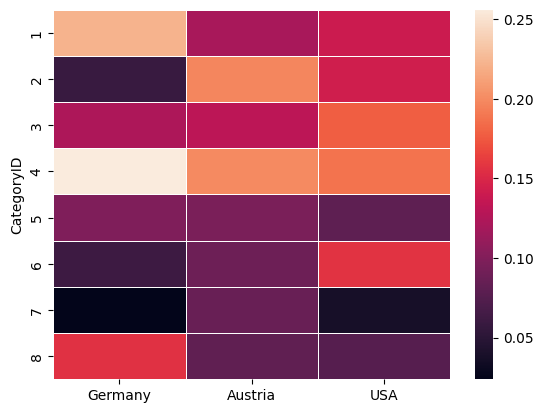

In [35]:
import seaborn as sns

# Join the 3 series
dfnormalizedCategoriesGermany = normalizedCategoriesGermany.to_frame()
dfnormalizedCategoriesAustria = normalizedCategoriesAustria.to_frame()
dfnormalizedCategoriesUSA = normalizedCategoriesUSA.to_frame()

outlierCountries = dfnormalizedCategoriesGermany.join(dfnormalizedCategoriesAustria).join(dfnormalizedCategoriesUSA)

print(outlierCountries)

#heat = outlierCountries.pivot(index="CategoryID", columns="Task", values="Score")
sns.heatmap(outlierCountries, linewidth=.5)



We can infer from the heatmap that the countries don't seem to have the same distribution of categories.